In [2]:
import dask.dataframe as dd

# 使用 Dask 读取合并后的数据
merged_data_file = 'merged_fire_data.csv'
merged = dd.read_csv(merged_data_file)

# 确保 Dask DataFrame 中 FDID 是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  
0                  5.0  
1                 54.0  
2                  6.0  
3                 67.0  
4                 44.0  


In [4]:
import pandas as pd

# 获取前 1000 行数据（如果有的话）
sample = merged[['FDID', 'RESPONSE_TIME']].head(1000)
print(sample)


      FDID  RESPONSE_TIME
0    10005            5.0
1    10005            5.0
2    10005            6.0
3    10005            5.0
4    10005            4.0
..     ...            ...
749  10030            5.0
750  10030            4.0
751  10030            5.0
752  10030            5.0
753  10030            6.0

[754 rows x 2 columns]


/opt/conda/lib/python3.11/site-packages/dask/dataframe/core.py:8114: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 754 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [6]:
import geopandas as gpd

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 将 sample 直接作为 Pandas DataFrame
merged_df = sample

# 合并数据
merged_gdf = gdf.merge(merged_df, on='FDID')

# 显示前几行，确保数据正确合并
print(merged_gdf.head())


   County   FDID MACSID       Name          Address    City    Zip  FireChief  \
0  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
1  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
2  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
3  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
4  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   

            Phone Notes  LastUpdate Website CALFIREUni  \
0  (559) 324-2201   NaN  2022-02-14     NaN        FKU   
1  (559) 324-2201   NaN  2022-02-14     NaN        FKU   
2  (559) 324-2201   NaN  2022-02-14     NaN        FKU   
3  (559) 324-2201   NaN  2022-02-14     NaN        FKU   
4  (559) 324-2201   NaN  2022-02-14     NaN        FKU   

                                            geometry  RESPONSE_TIME  
0  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0  
1  MULTIPOLYGON (((34471

Error fetching basemap: cannot identify image file <_io.BytesIO object at 0xffff0d95f7e0>


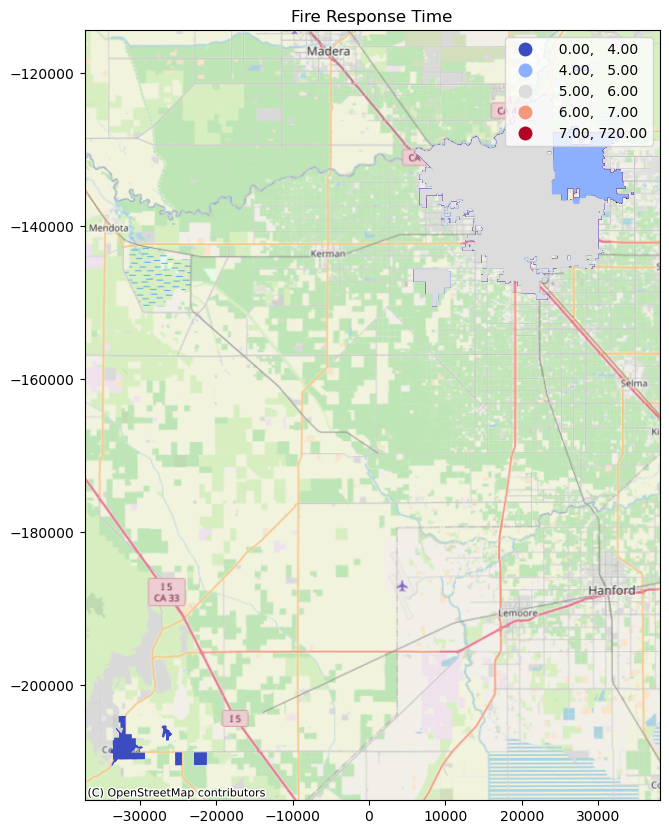

In [11]:
import matplotlib.pyplot as plt
import contextily as ctx

# 创建一个图形
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 绘制响应时间地图
merged_gdf.plot(column='RESPONSE_TIME', cmap='coolwarm', scheme='quantiles', k=5, legend=True, ax=ax)
ax.set_title('Fire Response Time')

# 尝试使用不同的瓦片地图资源
try:
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
except Exception as e:
    print(f"Error fetching basemap: {e}")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


In [2]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd

# 使用 Dask 读取合并后的数据
merged_data_file = 'merged_fire_data.csv'
merged = dd.read_csv(merged_data_file)

# 确保 Dask DataFrame 中 FDID 是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)


In [ ]:
# 文件路径
response_time_data_file = 'merged_fire_data.csv'
chunk_size = 100000  # 根据内存情况调整

# 初始化空的 GeoDataFrame 用于合并数据
merged_gdf = gpd.GeoDataFrame()

# 分块读取数据并合并
for chunk in pd.read_csv(response_time_data_file, chunksize=chunk_size):
    chunk['FDID'] = chunk['FDID'].astype(str)
    merged_chunk_gdf = gdf.merge(chunk, on='FDID')
    merged_gdf = pd.concat([merged_gdf, merged_chunk_gdf], ignore_index=True)
    print(f'Processed {len(merged_gdf)} rows')

# 确保合并后的 GeoDataFrame 使用相同的 CRS
merged_gdf = merged_gdf.set_crs(epsg=4326, allow_override=True)

# 保存处理后的数据以便后续使用
merged_gdf.to_file('merged_fire_data_processed.shp')


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 读取处理后的数据
merged_gdf = gpd.read_file('merged_fire_data_processed.shp')

# 创建一个图形
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 绘制响应时间地图
merged_gdf.plot(column='RESPONSE_TIME', cmap='coolwarm', scheme='quantiles', k=5, legend=True, ax=ax)
ax.set_title('Fire Response Time')

# 添加底图
ctx.add_basemap(ax, crs=merged_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


In [ ]:
print(merged_gdf.crs)
print(merged_gdf.total_bounds)

# 检查数据的边界是否在加州范围内
minx, miny, maxx, maxy = merged_gdf.total_bounds
print(f"Bounds: {minx}, {miny}, {maxx}, {maxy}")

# 确保数据在加州范围内（加州大致范围是：-124.48, 32.53, -114.13, 42.01）
if minx < -124.48 or maxx > -114.13 or miny < 32.53 or maxy > 42.01:
    print("数据超出加州范围，请检查坐标参考系统（CRS）")
